Tests various Convolutional Neural Networks on and abridged version of the the Functional Map of the World dataset.

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import numpy as np

We will be using tensorflow-metal with tensorflow-macos to run on this device GPU.

In [3]:
# check if TensorFlow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Tensorflow version: ", tf.__version__)
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
Tensorflow version:  2.16.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
print("Loading full training dataset for cropped and uncropped images...")
uncropped_train_ds = tf.keras.utils.image_dataset_from_directory(
    './combined_fmow_msrgb_dataset/train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123
)

# load full training dataset
cropped_train_ds = tf.keras.utils.image_dataset_from_directory(
    './fmow_msrgb_dataset_cropped/images/train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123
)

print("\nLoading full training dataset for cropped and uncropped images...")
uncropped_val_ds = tf.keras.utils.image_dataset_from_directory(
    './combined_fmow_msrgb_dataset/val',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
    seed=123
)

cropped_val_ds = tf.keras.utils.image_dataset_from_directory(
    './fmow_msrgb_dataset_cropped/images/val',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
    seed=123
)

Loading full training dataset for cropped and uncropped images...
Found 40012 files belonging to 10 classes.


2025-05-08 16:13:21.026486: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-05-08 16:13:21.026668: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-05-08 16:13:21.026686: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-05-08 16:13:21.027058: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-08 16:13:21.027105: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 40012 files belonging to 10 classes.

Loading full training dataset for cropped and uncropped images...
Found 5671 files belonging to 10 classes.
Found 5671 files belonging to 10 classes.


### Check the distribution of classes

In [6]:
# define actual class names
classes = [
    "electric_substation", "factory_or_powerplant", "gas_station",
    "nuclear_powerplant", "oil_or_gas_facility", "solar_farm", 
    "space_facility", "waste_disposal", "water_treatment_facility", "wind_farm"
]

2025-05-08 16:13:39.708757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


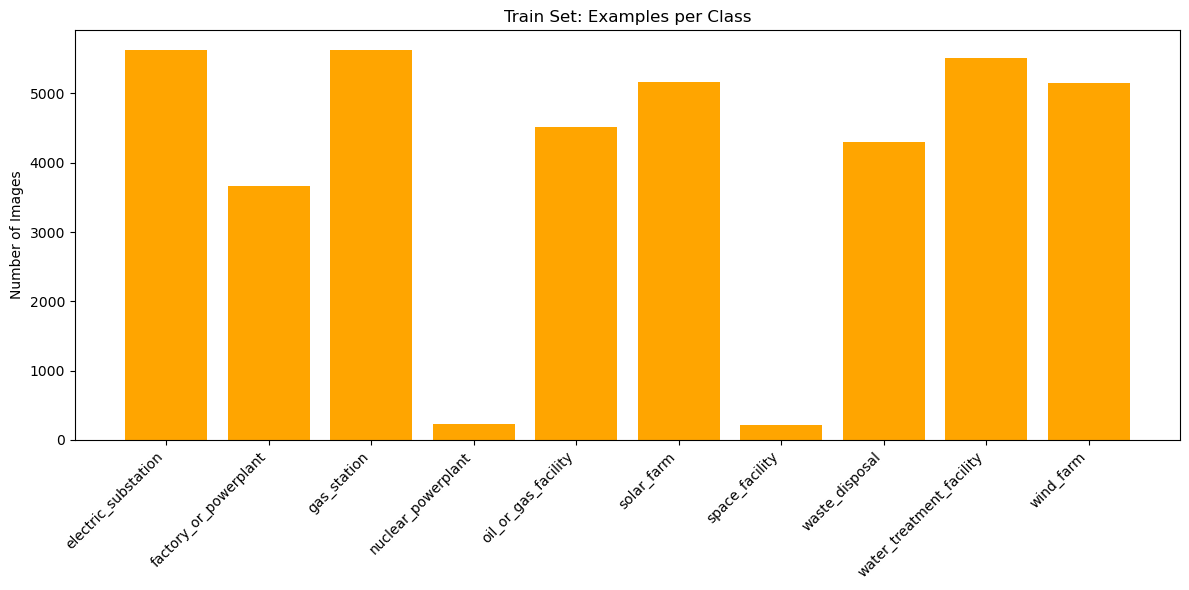

In [ ]:
# collect class labels from the dataset (cropped vs. uncropped will be the same)
label_list = []
for _, labels in cropped_train_ds:
    label_list.extend(labels.numpy())

# count occurences of each class
label_array = np.array(label_list)
class_counts = np.bincount(label_array, minlength=10)  # 10 classes expected

# visualize
plt.figure(figsize=(12, 6))
plt.bar(classes, class_counts, color='orange')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Images")
plt.title("Train Set: Examples per Class")
plt.tight_layout()
plt.show()

## Method 1: Class weighting

In [7]:
# Extract labels from dataset
y_train = []
for _, labels in cropped_train_ds.unbatch():
    y_train.append(int(labels.numpy()))
y_train = np.array(y_train)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

2025-05-08 16:14:09.956904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
# maintain the original classification head, as we have more results for that
def build_and_train_model(model_fn, name, train_ds, val_ds, num_classes=10, epochs=10, diy=False):

    if not diy:
        # 1. load and freeze the base model
        base_model = model_fn(weights='imagenet', include_top=False, 
                                input_shape=(224, 224, 3))
        base_model.trainable = False
        # 2. build the full model
        model = models.Sequential()
        model.add(base_model)
        model.add(layers.GlobalAveragePooling2D())
        model.add(layers.Dense(256, activation='relu'))
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dense(num_classes, activation='softmax'))
    else:
        model = model_fn

    # 3. Compile
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

    # 4. Callbacks
    tb_cb = TensorBoard(log_dir=f'./logs/{name}', update_freq='epoch')
    best_model_cb = ModelCheckpoint( f'saved_models/{name}.keras',
                        monitor='val_sparse_categorical_accuracy',
                        mode='max', save_best_only=True, verbose=1)
    early_cb = EarlyStopping(monitor='val_sparse_categorical_accuracy',
                        patience=5, restore_best_weights=True, verbose=1)

    # 5. Train
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, 
                        callbacks=[tb_cb, best_model_cb, early_cb],
                        class_weight=class_weights)

    return model, history

In [ ]:
# check difference on diy vgg, which initially predicted the underrepresented classes 0%
vgg_diy = models.Sequential()

# three groups of 2 conv 1 pool
vgg_diy.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), padding='same'))
vgg_diy.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
vgg_diy.add(layers.MaxPooling2D((2, 2)))

vgg_diy.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
vgg_diy.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
vgg_diy.add(layers.MaxPooling2D((2, 2)))

vgg_diy.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
vgg_diy.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
vgg_diy.add(layers.MaxPooling2D((2, 2)))

# flatten the 3D output to 1D
vgg_diy.add(layers.Flatten())

# fully connected layers
vgg_diy.add(layers.Dropout(0.5)) # add dropout to reduce overfitting
vgg_diy.add(layers.Dense(128, activation='relu'))
vgg_diy.add(layers.Dense(32, activation='relu')) 
vgg_diy.add(layers.Dense(10, activation='softmax'))

# before adding global avg pooling
build_and_train_model(vgg_diy, "class_weights/vgg_diy", cropped_train_ds, cropped_val_ds, diy=True)

/Users/maddysilveira/anaconda3/envs/tf-metal/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


2025-05-08 14:54:21.711895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - loss: 24.3676 - sparse_categorical_accuracy: 0.1035
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.14795, saving model to saved_models/class_weights/vgg_diy.keras
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 470s 371ms/step - loss: 24.3555 - sparse_categorical_accuracy: 0.1036 - val_loss: 2.2591 - val_sparse_categorical_accuracy: 0.1479
Epoch 2/10
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - loss: 2.3373 - sparse_categorical_accuracy: 0.1184
Epoch 2: val_sparse_categorical_accuracy did not improve from 0.14795
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 565s 451ms/step - loss: 2.3374 - sparse_categorical_accuracy: 0.1184 - val_loss: 2.3244 - val_sparse_categorical_accuracy: 0.0965
Epoch 3/10
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - loss: 2.2893 - sparse_categorical_accuracy: 0.0926
Epoch 3: val_sparse_categorical_accuracy did not improve from 0.14795
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 611s 488ms/step - loss: 2.2893 - sparse_categorical_accuracy

In [ ]:
from tensorflow.keras.applications import ResNet50
resnet50_model, resnet50_history = build_and_train_model(ResNet50, 
                                    "class_weights/resnet50", 
                                    cropped_train_ds, cropped_val_ds)

Epoch 1/10


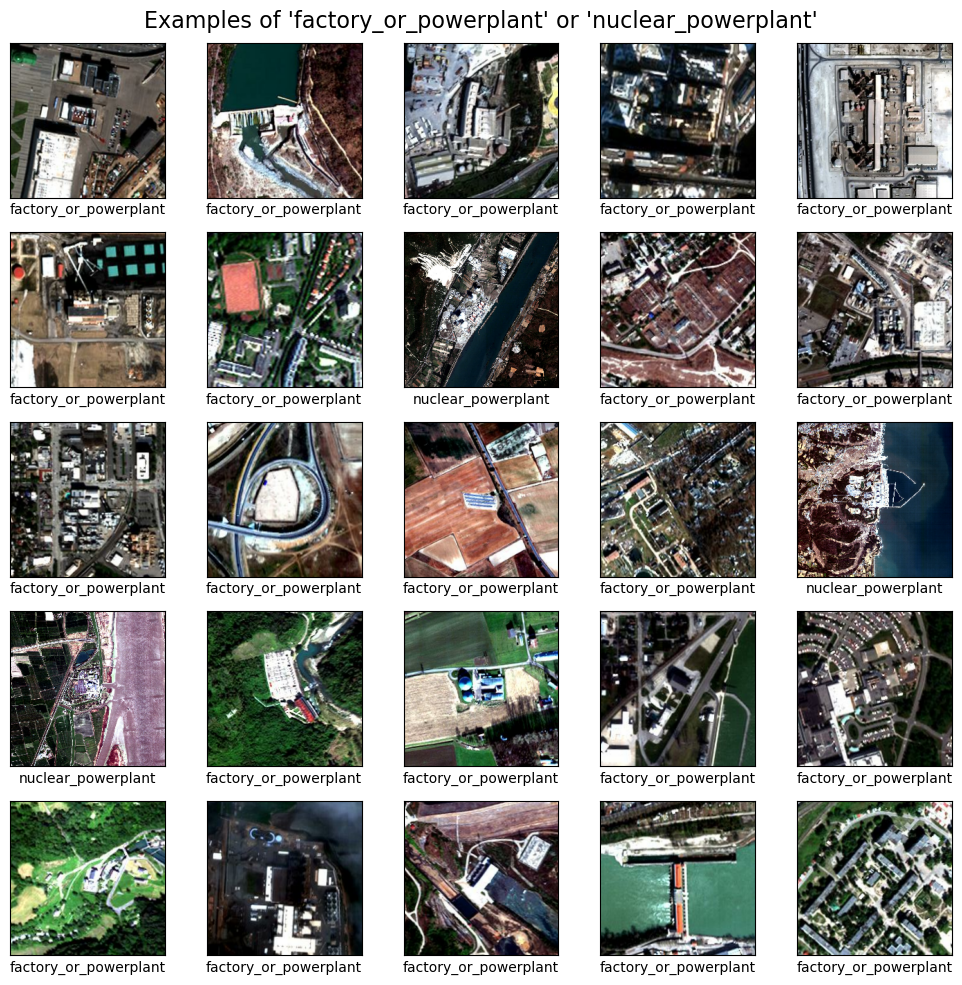

In [13]:
class_names = cropped_train_ds.class_names
factory_idx = class_names.index("factory_or_powerplant")
nuclear_idx = class_names.index("nuclear_powerplant")

plt.figure(figsize=(10, 10))
plotted = 0
for images, labels in cropped_train_ds:
    for i in range(len(labels)):
        if labels[i] == factory_idx or labels[i] == nuclear_idx:
            plt.subplot(5, 5, plotted + 1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.xlabel(class_names[labels[i]])
            plotted += 1
            if plotted == 25:
                break
    if plotted == 25:
        break
plt.suptitle("Examples of 'factory_or_powerplant' or 'nuclear_powerplant'", fontsize=16)
plt.tight_layout()
plt.show()

## Revaluate models on balanced classes

Let's see how the VGG architecture performs when trained from scratch on the uncropped images only.

In [ ]:
!tensorboard --logdir=logs/vgg

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.16.2 at http://localhost:6006/ (Press CTRL+C to quit)
^C


That took about 10 min per Epoch, and hit the early stopping callback at Epoch 13 (123 minutes totalruntime). It made me realize I should update the early stopping callback to use val_sparse_categorical_accuracy and restore the best weights to the saved variable, not just the saved model. Looking at the Tensorboard, it seems like the accuracy peaked at Epoch 8 with 0.1454 sparse_catagorical_accuracy and 0.16364 val_sparse_categorical_accuracy. Then both accuracies started going down, indicative of overfitting.

We can check the test accuracy when we have the test folders organized. We just need to load "best_model.h5".

In [ ]:
# scratch_vgg = tf.keras.models.load_model('best_model.h5')
# test_loss, test_accuracy = scratch_vgg.evaluate(test_ds)
# print(f"Test Accuracy: {test_accuracy:.4f}")

Now let's see how much better it is to use the VGG architecture pretrained on ImageNet instead of the scratch training.

In [ ]:
# start with VGG16, try also VGG19 (then ResNet50, ResNet151, DenseNet161)
from tensorflow.keras.applications import VGG16

# load the VGG16 model pretrained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False,
                   input_shape=(224, 224, 3))

# freeze the base model to maximize training on the new dataset
base_model.trainable = False
vgg16 = models.Sequential()
vgg16.add(base_model)   

# then add your own classifier on top
vgg16.add(layers.Flatten())
vgg16.add(layers.Dense(256, activation='relu'))
vgg16.add(layers.Dense(32, activation='relu'))
vgg16.add(layers.Dense(10, activation='softmax'))

# compile the model
vgg16.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                metrics=['sparse_categorical_accuracy'])

# update callbacks
tbcb_vgg16 = callbacks.TensorBoard(log_dir='./logs/vgg16', update_freq='epoch')
early_cb = callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', 
                                   patience=5, restore_best_weights=True)
best_model_cb = ModelCheckpoint("vgg16_best.keras", # updated file format
                    monitor="val_sparse_categorical_accuracy", mode="max",
                    save_best_only=True, verbose=1, save_traces=False)

# train the model on fmow msrgb dataset
vgg16.fit(train_ds, validation_data=val_ds, epochs=30,
    callbacks=[tbcb_vgg16, early_cb, best_model_cb])

Epoch 1/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - loss: 82.8917 - sparse_categorical_accuracy: 0.4131
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.46112, saving model to vgg16_best.h5


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 979s 782ms/step - loss: 82.8742 - sparse_categorical_accuracy: 0.4132 - val_loss: 74.5301 - val_sparse_categorical_accuracy: 0.4611
Epoch 2/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - loss: 41.4394 - sparse_categorical_accuracy: 0.6050
Epoch 2: val_sparse_categorical_accuracy improved from 0.46112 to 0.49621, saving model to vgg16_best.h5


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1021s 816ms/step - loss: 41.4380 - sparse_categorical_accuracy: 0.6050 - val_loss: 69.5297 - val_sparse_categorical_accuracy: 0.4962
Epoch 3/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - loss: 38.8512 - sparse_categorical_accuracy: 0.6627
Epoch 3: val_sparse_categorical_accuracy improved from 0.49621 to 0.51966, saving model to vgg16_best.h5


1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1025s 819ms/step - loss: 38.8494 - sparse_categorical_accuracy: 0.6627 - val_loss: 89.6628 - val_sparse_categorical_accuracy: 0.5197
Epoch 4/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - loss: 39.5054 - sparse_categorical_accuracy: 0.7103
Epoch 4: val_sparse_categorical_accuracy did not improve from 0.51966
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1017s 813ms/step - loss: 39.5040 - sparse_categorical_accuracy: 0.7103 - val_loss: 121.0992 - val_sparse_categorical_accuracy: 0.5123
Epoch 5/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - loss: 40.0657 - sparse_categorical_accuracy: 0.7412
Epoch 5: val_sparse_categorical_accuracy did not improve from 0.51966
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1030s 823ms/step - loss: 40.0636 - sparse_categorical_accuracy: 0.7413 - val_loss: 151.2856 - val_sparse_categorical_accuracy: 0.5165
Epoch 6/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - loss: 39.3600 - sparse_categorical_accuracy: 0.7762
Epoch 6: val_sparse_categorical_accu

1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1024s 818ms/step - loss: 39.3608 - sparse_categorical_accuracy: 0.7762 - val_loss: 184.3947 - val_sparse_categorical_accuracy: 0.5302
Epoch 7/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step - loss: 36.9573 - sparse_categorical_accuracy: 0.8045
Epoch 7: val_sparse_categorical_accuracy did not improve from 0.53024
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1022s 817ms/step - loss: 36.9567 - sparse_categorical_accuracy: 0.8045 - val_loss: 209.1798 - val_sparse_categorical_accuracy: 0.5200
Epoch 8/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - loss: 36.7959 - sparse_categorical_accuracy: 0.8169
Epoch 8: val_sparse_categorical_accuracy did not improve from 0.53024
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 1107s 885ms/step - loss: 36.7971 - sparse_categorical_accuracy: 0.8169 - val_loss: 233.2569 - val_sparse_categorical_accuracy: 0.5001
Epoch 9/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - loss: 44.1401 - sparse_categorical_accuracy: 0.8120
Epoch 9: val_sparse_categorical_acc

1251/1251 ━━━━━━━━━━━━━━━━━━━━ 996s 796ms/step - loss: 48.5979 - sparse_categorical_accuracy: 0.8208 - val_loss: 342.5235 - val_sparse_categorical_accuracy: 0.5345
Epoch 11/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - loss: 56.3635 - sparse_categorical_accuracy: 0.8189
Epoch 11: val_sparse_categorical_accuracy did not improve from 0.53447
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 903s 722ms/step - loss: 56.3637 - sparse_categorical_accuracy: 0.8189 - val_loss: 417.9865 - val_sparse_categorical_accuracy: 0.5089
Epoch 12/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - loss: 62.5799 - sparse_categorical_accuracy: 0.8311
Epoch 12: val_sparse_categorical_accuracy did not improve from 0.53447
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 886s 708ms/step - loss: 62.5799 - sparse_categorical_accuracy: 0.8311 - val_loss: 480.7057 - val_sparse_categorical_accuracy: 0.5112
Epoch 13/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - loss: 66.8692 - sparse_categorical_accuracy: 0.8407
Epoch 13: val_sparse_categorical_

In [ ]:
!tensorboard --logdir=logs/vgg16

That took about 15 min per epoch

Let's define a function to run all pretrained models on the same additional architecture as above.

In [ ]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

def build_and_train_model(model_fn, name, train_ds, val_ds, num_classes=10, epochs=30):

    # 1. load and freeze the base model
    base_model = model_fn(weights='imagenet', include_top=False, 
                               input_shape=(224, 224, 3))
    base_model.trainable = False

    # 2. build the full model
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    # 3. Compile
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

    # 4. Callbacks
    tb_cb = TensorBoard(log_dir=f'./logs/{name}', update_freq='epoch')
    best_model_cb = ModelCheckpoint( f'{name}.keras',
                        monitor='val_sparse_categorical_accuracy',
                        mode='max', save_best_only=True, verbose=1)
    early_cb = EarlyStopping(monitor='val_sparse_categorical_accuracy',
                        patience=5, restore_best_weights=True, verbose=1)

    # 5. Train
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, 
                        callbacks=[tb_cb, best_model_cb, early_cb])

    return model, history


In [ ]:
from tensorflow.keras.applications import VGG19
vgg19_model, vgg19_history = build_and_train_model(VGG19, 'vgg19', 
                                train_ds, val_ds, num_classes=10, epochs=30)

In [ ]:
!tensorboard --logdir=logs/vgg19

In [ ]:
from tensorflow.keras.applications import ResNet50
resnet50_model, resnet50_history = build_and_train_model(ResNet50, 'resnet50', 
                                train_ds, val_ds, num_classes=10, epochs=30)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step
Epoch 1/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - loss: 56.4368 - sparse_categorical_accuracy: 0.4332
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.52795, saving model to resnet50_best.keras
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 736s 584ms/step - loss: 56.4164 - sparse_categorical_accuracy: 0.4333 - val_loss: 18.9707 - val_sparse_categorical_accuracy: 0.5279
Epoch 2/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - loss: 17.1707 - sparse_categorical_accuracy: 0.6439
Epoch 2: val_sparse_categorical_accuracy improved from 0.52795 to 0.54929, saving model to resnet50_best.keras
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 727s 581ms/step - loss: 17.1678 - sparse_categorical_accuracy: 0.6439 - val_loss: 21.9079 - val_sparse_categorical_accuracy: 0.5493
Epoch 3/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - loss: 9.4871 - sparse_categorical_accuracy: 0.7428
Epoch 3: val_sparse_categorical_accuracy did not improve from 0.54929
1251

In [ ]:
!tensorboard --logdir=logs/resnet50

python(33151) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.16.2 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [ ]:
from tensorflow.keras.applications import ResNet152
resnet152_model, resnet152_history = build_and_train_model(ResNet152, 'resnet152', 
                                train_ds, val_ds, num_classes=10, epochs=30)

In [ ]:
!tensorboard --logdir=logs/resnet152

In [ ]:
from tensorflow.keras.applications import DenseNet161
dense161_model, dense161_history = build_and_train_model(DenseNet161, 'dense161', 
                                train_ds, val_ds, num_classes=10, epochs=30)

We could get into unfreezing the base models.

# Models based on the cropped images.

In [37]:
# load full training dataset
cropped_train_ds = tf.keras.utils.image_dataset_from_directory(
    './fmow_msrgb_dataset_cropped/images/train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123
)

# load full validation dataset
cropped_val_ds = tf.keras.utils.image_dataset_from_directory(
    './fmow_msrgb_dataset_cropped/images/val',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
    seed=123
)

Found 40012 files belonging to 10 classes.
Found 5671 files belonging to 10 classes.


In [ ]:
vgg16_cropped_model, vgg16_cropped_history = build_and_train_model(VGG16, 'vgg16_cropped', 
                                cropped_train_ds, cropped_val_ds, num_classes=10, epochs=30)

Epoch 1/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - loss: 70.9374 - sparse_categorical_accuracy: 0.4627
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.51226, saving model to vgg16_cropped_best.keras
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 864s 689ms/step - loss: 70.9183 - sparse_categorical_accuracy: 0.4627 - val_loss: 41.8121 - val_sparse_categorical_accuracy: 0.5123
Epoch 2/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - loss: 33.7999 - sparse_categorical_accuracy: 0.5857
Epoch 2: val_sparse_categorical_accuracy did not improve from 0.51226
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 912s 730ms/step - loss: 33.8020 - sparse_categorical_accuracy: 0.5857 - val_loss: 53.8156 - val_sparse_categorical_accuracy: 0.5094
Epoch 3/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - loss: 36.8449 - sparse_categorical_accuracy: 0.6195
Epoch 3: val_sparse_categorical_accuracy did not improve from 0.51226
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 937s 749ms/step - loss: 36.8471 - sparse_categorical_accurac

In [ ]:
rn50_cropped_model, rn50_cropped_history = build_and_train_model(ResNet50, 'rn50_cropped', 
                                cropped_train_ds, cropped_val_ds, num_classes=10, epochs=30)

Epoch 1/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - loss: 56.1523 - sparse_categorical_accuracy: 0.4753
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.51702, saving model to rn50_cropped_best.keras
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 826s 657ms/step - loss: 56.1360 - sparse_categorical_accuracy: 0.4753 - val_loss: 29.6135 - val_sparse_categorical_accuracy: 0.5170
Epoch 2/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - loss: 26.6133 - sparse_categorical_accuracy: 0.5898
Epoch 2: val_sparse_categorical_accuracy did not improve from 0.51702
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 792s 633ms/step - loss: 26.6145 - sparse_categorical_accuracy: 0.5898 - val_loss: 37.3507 - val_sparse_categorical_accuracy: 0.5043
Epoch 3/30
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - loss: 33.2189 - sparse_categorical_accuracy: 0.5836
Epoch 3: val_sparse_categorical_accuracy did not improve from 0.51702
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 784s 627ms/step - loss: 33.2163 - sparse_categorical_accuracy

### Change the Model Schema

Still haven't unfrozen the model. I'm gonna test a few different methods on Resnet50 to see what happens.

https://saturncloud.io/blog/understanding-the-difference-between-flatten-and-globalaveragepooling2d-in-keras/#:~:text=with%20nine%20elements.-,What%20is%20GlobalAveragePooling2D()%20in%20Keras%3F,an%20operation%20on%20the%20data.
1) Change Flatten to GlobalAveragePooling2D: Instead of simply reshaping the 
dimensions like Flatten, GlobalAveragePooling2D actually reduces the spatial 
dimensions (and parameters) via a pooling operations. This helps prevent 
overfitting, particularly for complicated models like ResNet.

2) Make the new epoch default 14 because that's how long resnet ran before.

In [ ]:
def build_and_train_pooling(model_fn, name, train_ds, val_ds, epochs=14):

    # 1. load and freeze the base model
    base_model = model_fn(weights='imagenet', include_top=False, 
                               input_shape=(224, 224, 3))
    base_model.trainable = False

    # 2. build the full model
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    # 3. Compile
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

    # 4. Callbacks
    tb_cb = TensorBoard(log_dir=f'./logs/{name}_pooled', update_freq='epoch')
    best_model_cb = ModelCheckpoint( f'saved_models/{name}_pooling.keras',
                        monitor='val_sparse_categorical_accuracy',
                        mode='max', save_best_only=True, verbose=1)
    early_cb = EarlyStopping(monitor='val_sparse_categorical_accuracy',
                        patience=5, restore_best_weights=True, verbose=1)

    # 5. Train
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, 
                        callbacks=[tb_cb, best_model_cb, early_cb])

    return model, history


In [ ]:
rn50_cr_md_pooled, rn50_cr_hist_pooled = build_and_train_pooling(ResNet50, 
                                            'rn50_cropped', 
                                            cropped_train_ds, cropped_val_ds, 
                                            epochs=14)

Epoch 1/14
1229/1251 ━━━━━━━━━━━━━━━━━━━━ 7:44 21s/step - loss: 2.6231 - sparse_categorical_accuracy: 0.3325

KeyboardInterrupt: 

In [ ]:
rn50_cr_md_pooled, rn50_cr_hist_pooled = build_and_train_pooling(ResNet50, 
                                            'rn50_uncropped', 
                                            uncropped_train_ds, uncropped_val_ds, 
                                            epochs=14)

### Add dropout

In [ ]:
def build_and_train_pooling(model_fn, name, train_ds, val_ds, epochs=14):

    # 1. load and freeze the base model
    base_model = model_fn(weights='imagenet', include_top=False, 
                               input_shape=(224, 224, 3))
    base_model.trainable = False

    # 2. build the full model
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5)) 
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    # 3. Compile
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

    # 4. Callbacks
    tb_cb = TensorBoard(log_dir=f'./logs/{name}', update_freq='epoch')
    best_model_cb = ModelCheckpoint( f'saved_models/{name}_pooling_dropout.keras',
                        monitor='val_sparse_categorical_accuracy',
                        mode='max', save_best_only=True, verbose=1)
    early_cb = EarlyStopping(monitor='val_sparse_categorical_accuracy',
                        patience=5, restore_best_weights=True, verbose=1)

    # 5. Train
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, 
                        callbacks=[tb_cb, best_model_cb, early_cb])

    return model, history

## Evaluate the models on test data.

In [ ]:
# save the test dataset to a variable
test_ds_uncropped = tf.keras.utils.image_dataset_from_directory(
    './combined_fmow_msrgb_dataset/test/test_gt',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
    seed=123
)

class_names = test_ds_uncropped.class_names

# this should make evaluation go quicker via parallelization
test_ds_uncropped = test_ds_uncropped.prefetch(tf.data.AUTOTUNE)

Found 5824 files belonging to 10 classes.


In [ ]:
# load and evaluate the saved model (vgg from scratch)
model = tf.keras.models.load_model('saved_models/best_model.h5')
loss, acc = model.evaluate(test_ds_uncropped)

2025-05-08 06:32:21.739710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


182/182 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - loss: 9933924.0000 - sparse_categorical_accuracy: 0.0903


In [ ]:
print(f"Test Accuracy: {acc:.4f}")
print(f"Test loss: {loss:.0f}")

Test Accuracy: 0.1549
Test loss: 10743736


In [ ]:
import numpy as np

# Get ground truth labels and model predictions
y_true = []
y_pred = []

for images, labels in test_ds_uncropped:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

2025-05-08 06:33:58.217472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


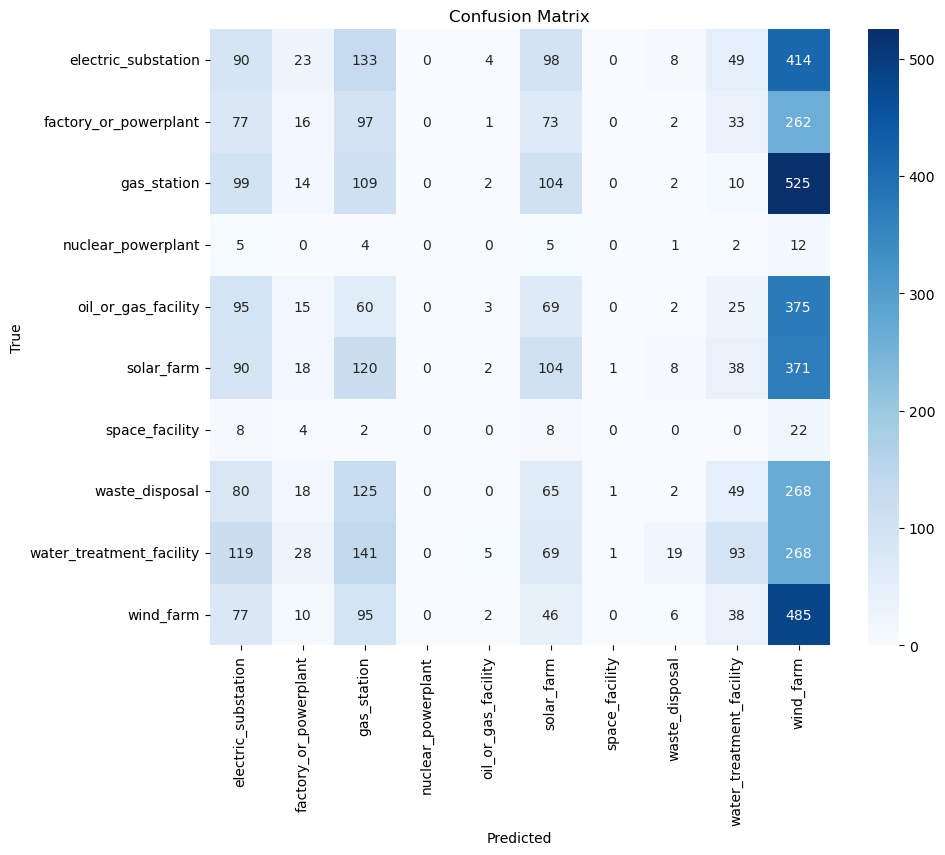

                          precision    recall  f1-score   support

     electric_substation      0.122     0.110     0.115       819
   factory_or_powerplant      0.110     0.029     0.045       561
             gas_station      0.123     0.126     0.125       865
      nuclear_powerplant      0.000     0.000     0.000        29
     oil_or_gas_facility      0.158     0.005     0.009       644
              solar_farm      0.162     0.138     0.149       752
          space_facility      0.000     0.000     0.000        44
          waste_disposal      0.040     0.003     0.006       608
water_treatment_facility      0.276     0.125     0.172       743
               wind_farm      0.162     0.639     0.258       759

                accuracy                          0.155      5824
               macro avg      0.115     0.117     0.088      5824
            weighted avg      0.145     0.155     0.116      5824



/Users/maddysilveira/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/maddysilveira/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/maddysilveira/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [ ]:
# install scikit-learn
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrices/uncropped_v1/best_model.png", dpi=300)
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

Woah woah woah. I should have been checking the validation cms bc I think the data needs to be readjusted. Let's make a function to call on many models

In [ ]:
def evaluate_model(model, ds, destination_path):
    loss, acc = model.evaluate(ds)
    print(f"Accuracy: {acc:.4f}")
    print(f"Loss: {loss:.4f}")

    # Get ground truth labels and model predictions
    y_true = []
    y_pred = []

    for images, labels in ds:
        preds = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.savefig(f"confusion_matrices/{destination_path}", dpi=300)
    plt.show()

    # Classification Report
    print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

### Generate validation confusion matrices

178/178 ━━━━━━━━━━━━━━━━━━━━ 66s 349ms/step - loss: 63.1334 - sparse_categorical_accuracy: 0.5439
Test Accuracy: 0.5925
Test Loss: 58.6470


2025-05-08 07:08:08.341963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


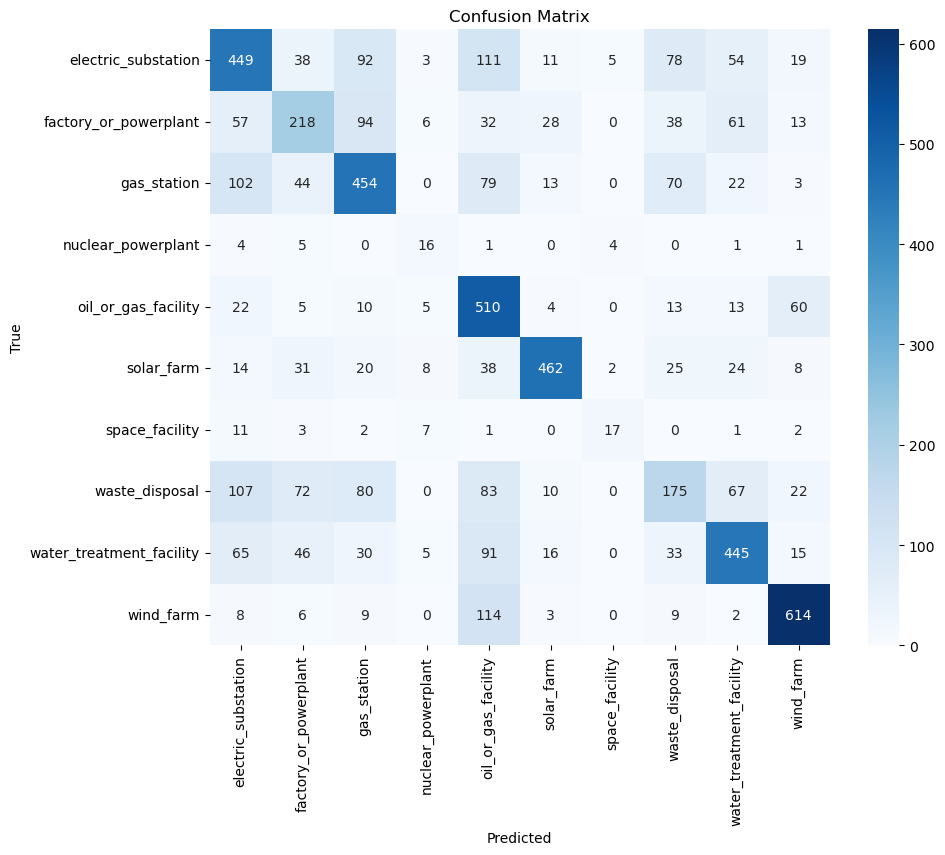

                          precision    recall  f1-score   support

     electric_substation      0.535     0.522     0.529       860
   factory_or_powerplant      0.466     0.399     0.430       547
             gas_station      0.574     0.577     0.575       787
      nuclear_powerplant      0.320     0.500     0.390        32
     oil_or_gas_facility      0.481     0.794     0.599       642
              solar_farm      0.845     0.731     0.784       632
          space_facility      0.607     0.386     0.472        44
          waste_disposal      0.397     0.284     0.331       616
water_treatment_facility      0.645     0.597     0.620       746
               wind_farm      0.811     0.803     0.807       765

                accuracy                          0.592      5671
               macro avg      0.568     0.559     0.554      5671
            weighted avg      0.598     0.592     0.589      5671



In [ ]:
# this should make evaluation go quicker via parallelization
val_ds_uncropped = val_ds.prefetch(tf.data.AUTOTUNE)
model = tf.keras.models.load_model("saved_models/uncropped/resnet50_best.keras")
evaluate_model(model, val_ds_uncropped, "validation/uncropped_v1/rn50.png")

178/178 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - loss: 9835715.0000 - sparse_categorical_accuracy: 0.1011
Test Accuracy: 0.1636
Test Loss: 10851420.0000


2025-05-08 07:10:50.630844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


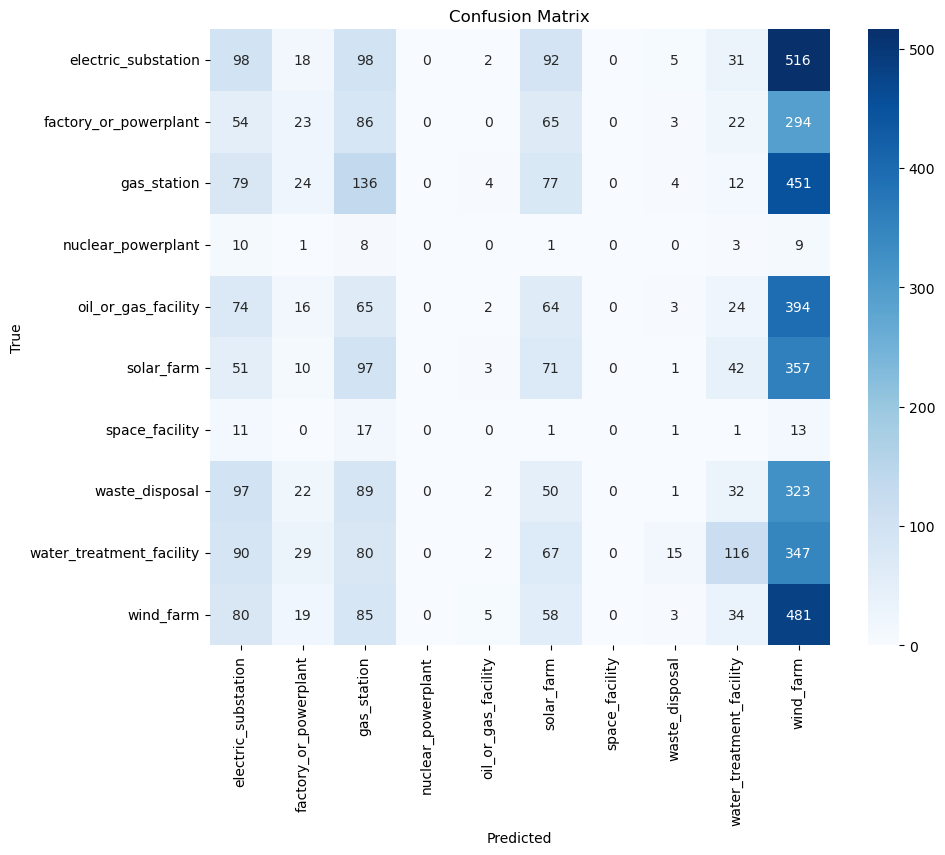

                          precision    recall  f1-score   support

     electric_substation      0.152     0.114     0.130       860
   factory_or_powerplant      0.142     0.042     0.065       547
             gas_station      0.179     0.173     0.176       787
      nuclear_powerplant      0.000     0.000     0.000        32
     oil_or_gas_facility      0.100     0.003     0.006       642
              solar_farm      0.130     0.112     0.121       632
          space_facility      0.000     0.000     0.000        44
          waste_disposal      0.028     0.002     0.003       616
water_treatment_facility      0.366     0.155     0.218       746
               wind_farm      0.151     0.629     0.244       765

                accuracy                          0.164      5671
               macro avg      0.125     0.123     0.096      5671
            weighted avg      0.159     0.164     0.126      5671



/Users/maddysilveira/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/maddysilveira/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/maddysilveira/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [ ]:
model = tf.keras.models.load_model("saved_models/uncropped/best_model.h5")
evaluate_model(model, val_ds_uncropped, "validation/uncropped_v1/vgg_diy.png")

178/178 ━━━━━━━━━━━━━━━━━━━━ 82s 457ms/step - loss: 368.6635 - sparse_categorical_accuracy: 0.4853
Test Accuracy: 0.5345
Test Loss: 342.5235


2025-05-08 07:16:48.645459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


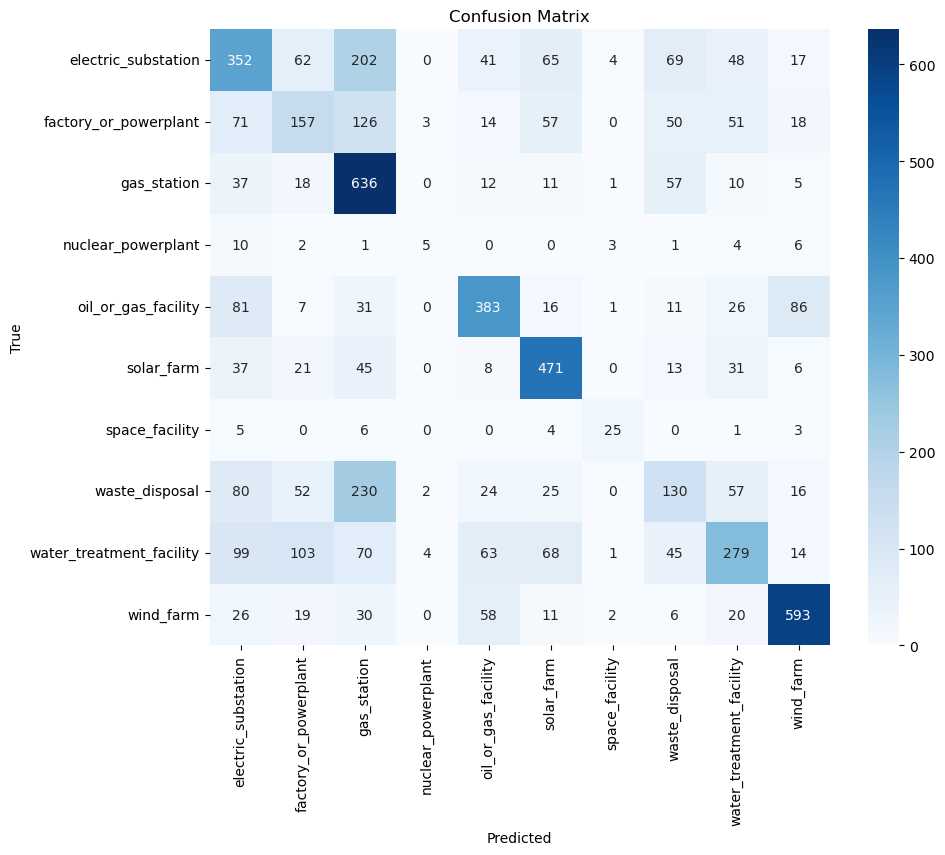

                          precision    recall  f1-score   support

     electric_substation      0.441     0.409     0.425       860
   factory_or_powerplant      0.356     0.287     0.318       547
             gas_station      0.462     0.808     0.588       787
      nuclear_powerplant      0.357     0.156     0.217        32
     oil_or_gas_facility      0.635     0.597     0.615       642
              solar_farm      0.647     0.745     0.693       632
          space_facility      0.676     0.568     0.617        44
          waste_disposal      0.340     0.211     0.261       616
water_treatment_facility      0.529     0.374     0.438       746
               wind_farm      0.776     0.775     0.776       765

                accuracy                          0.534      5671
               macro avg      0.522     0.493     0.495      5671
            weighted avg      0.528     0.534     0.520      5671



In [ ]:
model = tf.keras.models.load_model("saved_models/uncropped/vgg16_best.h5")
evaluate_model(model, val_ds_uncropped, "validation/uncropped_v1/vgg16.png")

178/178 ━━━━━━━━━━━━━━━━━━━━ 68s 366ms/step - loss: 103.3556 - sparse_categorical_accuracy: 0.5341
Test Accuracy: 0.5535
Test Loss: 104.1544


2025-05-08 07:22:43.764834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


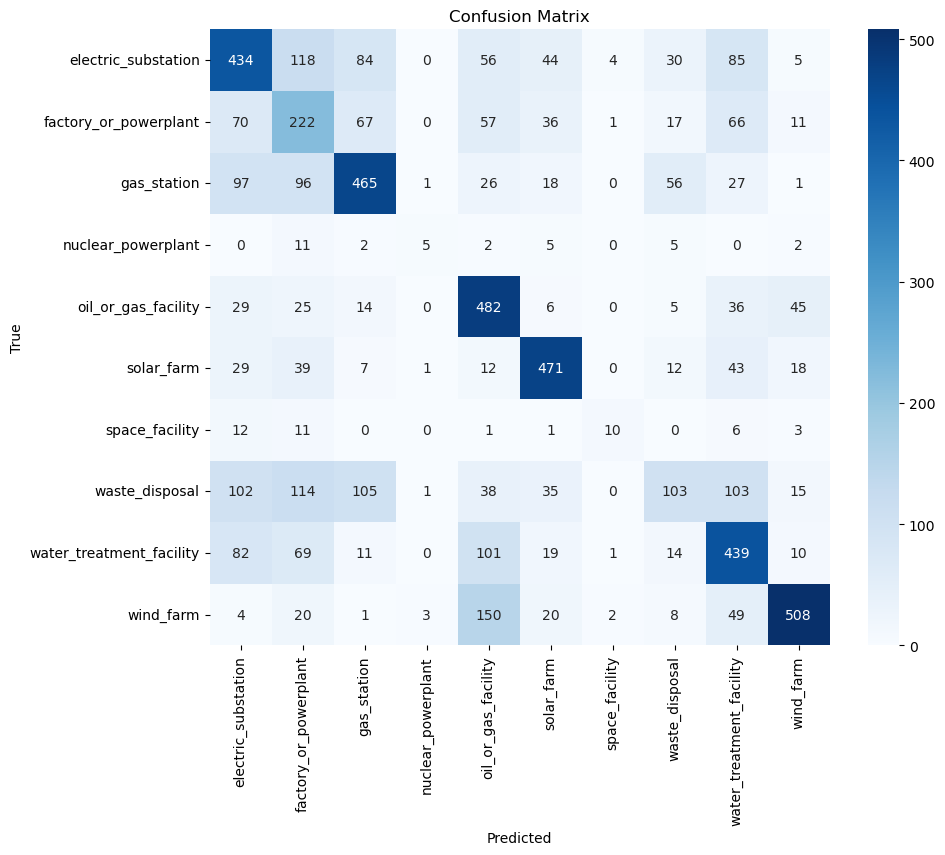

                          precision    recall  f1-score   support

     electric_substation      0.505     0.505     0.505       860
   factory_or_powerplant      0.306     0.406     0.349       547
             gas_station      0.615     0.591     0.603       787
      nuclear_powerplant      0.455     0.156     0.233        32
     oil_or_gas_facility      0.521     0.751     0.615       642
              solar_farm      0.719     0.745     0.732       632
          space_facility      0.556     0.227     0.323        44
          waste_disposal      0.412     0.167     0.238       616
water_treatment_facility      0.514     0.588     0.549       746
               wind_farm      0.822     0.664     0.735       765

                accuracy                          0.554      5671
               macro avg      0.542     0.480     0.488      5671
            weighted avg      0.561     0.554     0.546      5671



In [39]:
# this should make evaluation go quicker via parallelization
val_ds_cropped = cropped_val_ds.prefetch(tf.data.AUTOTUNE)
model = tf.keras.models.load_model("saved_models/cropped/rn50_cropped_best.keras")
evaluate_model(model, val_ds_cropped, "validation/cropped_v1/rn50.png")

178/178 ━━━━━━━━━━━━━━━━━━━━ 90s 499ms/step - loss: 2038.0811 - sparse_categorical_accuracy: 0.1810
Test Accuracy: 0.2661
Test Loss: 1565.8734


2025-05-08 07:27:41.593425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


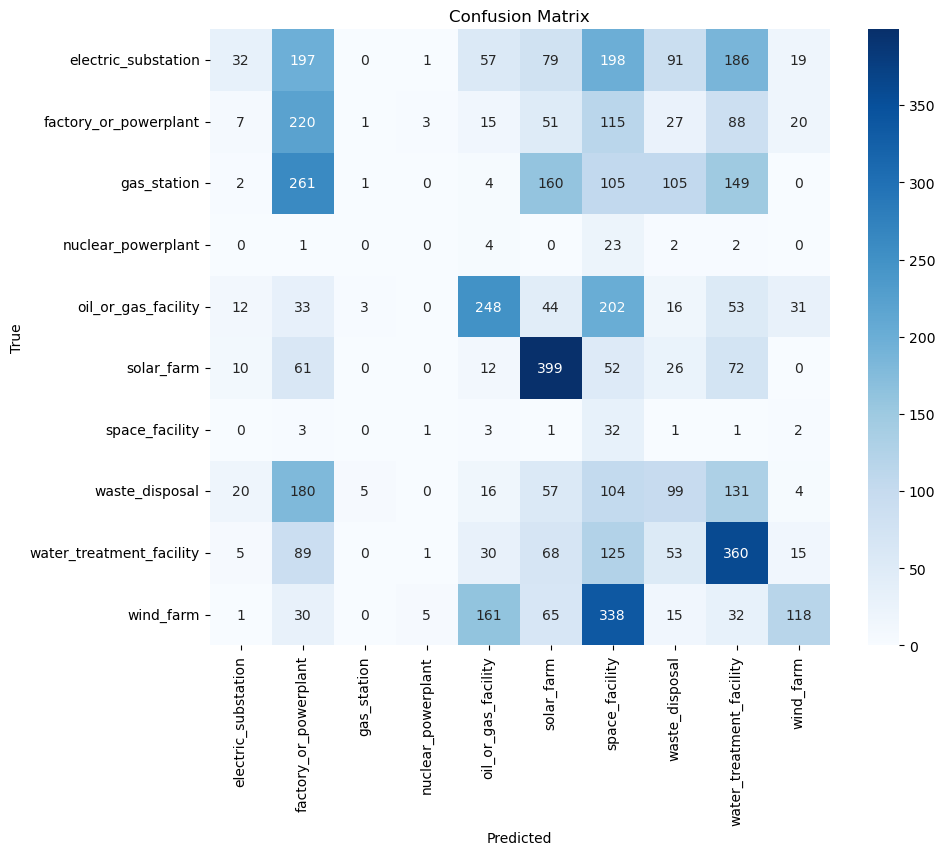

                          precision    recall  f1-score   support

     electric_substation      0.360     0.037     0.067       860
   factory_or_powerplant      0.205     0.402     0.271       547
             gas_station      0.100     0.001     0.003       787
      nuclear_powerplant      0.000     0.000     0.000        32
     oil_or_gas_facility      0.451     0.386     0.416       642
              solar_farm      0.432     0.631     0.513       632
          space_facility      0.025     0.727     0.048        44
          waste_disposal      0.228     0.161     0.188       616
water_treatment_facility      0.335     0.483     0.396       746
               wind_farm      0.565     0.154     0.242       765

                accuracy                          0.266      5671
               macro avg      0.270     0.298     0.214      5671
            weighted avg      0.332     0.266     0.247      5671



In [40]:
model = tf.keras.models.load_model("saved_models/cropped/vgg16_cropped_best.keras")
evaluate_model(model, val_ds_cropped, "validation/cropped_v1/vgg16.png")

178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - loss: 175821.3906 - sparse_categorical_accuracy: 0.1247
Test Accuracy: 0.1566
Test Loss: 210424.0156


2025-05-08 07:29:18.450324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


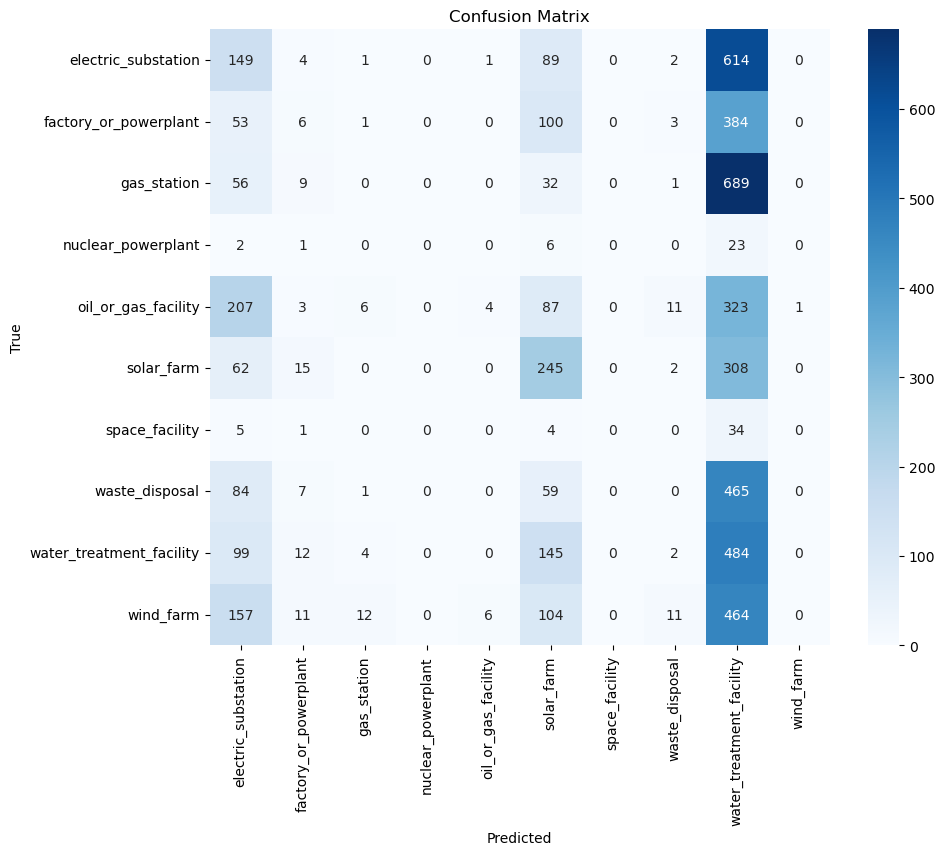

                          precision    recall  f1-score   support

     electric_substation      0.170     0.173     0.172       860
   factory_or_powerplant      0.087     0.011     0.019       547
             gas_station      0.000     0.000     0.000       787
      nuclear_powerplant      0.000     0.000     0.000        32
     oil_or_gas_facility      0.364     0.006     0.012       642
              solar_farm      0.281     0.388     0.326       632
          space_facility      0.000     0.000     0.000        44
          waste_disposal      0.000     0.000     0.000       616
water_treatment_facility      0.128     0.649     0.213       746
               wind_farm      0.000     0.000     0.000       765

                accuracy                          0.157      5671
               macro avg      0.103     0.123     0.074      5671
            weighted avg      0.124     0.157     0.094      5671



/Users/maddysilveira/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/maddysilveira/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/maddysilveira/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [41]:
model = tf.keras.models.load_model("saved_models/cropped/cropped_vgg_diy.keras")
evaluate_model(model, val_ds_cropped, "validation/cropped_v1/vgg_diy.png")

## Unfreezing the base models

1) Validation accuracy has plateaued with the frozen base.

2) Training loss is decreasing while validation accuracy is barely improving.

3) Thanks to GlobalAveragePooling2d and Dropout layers, the models are no longer  overfitting (training accuracy much higher than validation accuracy).

In [49]:
def build_and_train_unfrozen(model_fn, name, train_ds, val_ds, epochs=10):

    # 1. load the base model
    base_model = model_fn(weights='imagenet', include_top=False, 
                               input_shape=(224, 224, 3))
    # 1.5 Unfreeze it
    base_model.trainable = True

    # 2. build the full model
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    # 3. Compile
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                    loss='sparse_categorical_crossentropy',
                    metrics=['sparse_categorical_accuracy'])

    # 4. Callbacks
    tb_cb = callbacks.TensorBoard(log_dir=f'./logs/{name}_unfrozen', update_freq='epoch')
    best_model_cb = callbacks.ModelCheckpoint( f'saved_models/unfrozen/{name}.keras',
                        monitor='val_sparse_categorical_accuracy',
                        mode='max', save_best_only=True, verbose=1)
    early_cb = callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy',
                        patience=5, restore_best_weights=True, verbose=1)

    # 5. Train
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, 
                        callbacks=[tb_cb, best_model_cb, early_cb])

    return model, history

In [ ]:
from tensorflow.keras.applications import ResNet50
rn50_cr_unfr, rn50_cr_unfr_hist = build_and_train_unfrozen(ResNet50, 'rn50', 
                                        cropped_train_ds, cropped_val_ds)

Epoch 1/10
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 1.8842 - sparse_categorical_accuracy: 0.3922
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.64504, saving model to saved_models/unfrozen/rn50.keras
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 3400s 3s/step - loss: 1.8839 - sparse_categorical_accuracy: 0.3923 - val_loss: 1.0672 - val_sparse_categorical_accuracy: 0.6450
Epoch 2/10
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.8321 - sparse_categorical_accuracy: 0.7222
Epoch 2: val_sparse_categorical_accuracy improved from 0.64504 to 0.70393, saving model to saved_models/unfrozen/rn50.keras
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 3214s 3s/step - loss: 0.8320 - sparse_categorical_accuracy: 0.7222 - val_loss: 0.9268 - val_sparse_categorical_accuracy: 0.7039
Epoch 3/10
 615/1251 ━━━━━━━━━━━━━━━━━━━━ 2:39:40 15s/step - loss: 0.5114 - sparse_categorical_accuracy: 0.8364